# Notebook to show results

Import libraries needed

In [1]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import matplotlib.patches as mpatches

In [2]:
from modules.config import (RESULTS_DIR,
                            RESULTS_FILE, 
                            GRAPH_DIR,
                            )

SPACE = ' '
SHOW_COUNTS = False # Show how much many relevant datapoints have been read?  If False, the quality, or error will be shown instead.
CMAP = 'Set3'
CMAP_HEATMAP = 'cividis'

## Define standard function modules

In [3]:
def read_data():
    """read data from csv file into pandas dataframe"""
    results_path = Path(RESULTS_DIR).joinpath(RESULTS_FILE)
    df = pd.read_csv(results_path)
    return df

In [4]:
def filter_results_general(df):
    """based on standard parameters"""    
    df = df[(df['formulation'] == 'original')]
    df = df[(df['hot_start'] == False)]
    df = df[(df['gray'] == False)]
    df = df[(df['iterations'] == 250)]
    df = df[(df['noise'] != True)]
    return df

Filter out records for analysis

In [5]:
def filter_results_qml(df):
    """based on standard parameters"""    
    df = df[(df['quantum'] == True)]
    df = filter_results_general(df)
    df = df[(df['gradient_type'] == 'SPSA')]
    df = df[(df['alpha'] == 0.602)]
    df = df[(df['big_a'] == 25)]
    df = df[(df['c'] == 0.314)]
    df = df[(df['gamma'] == 0.101)]
    df = df[(df['eta'] == 0.1)]
    df = df[(df['s'] == 0.5)]
    df = df[(df['shots'] == 1024)]
    return df

In [6]:
def filter_results_ml(df):
    """based on standard parameters"""    
    df = df[(df['quantum'] == False)]
    df = filter_results_general(df)
    df = df[(df['shots'] == 64)]
    df = df[(df['std_dev'] == 0.05)]
    df = df[(df['lr'] == 2e-5)]
    df = df[(df['weight_decay'] == 0.0006)]
    df = df[(df['momentum'] == 0.8)]
    return df

In [7]:
def find_quality(df, factor=1, round=None):
    df['quality'] =  factor* df['best_dist'] / df['best_dist_found'] 
    df['error'] = 1 * factor - df['quality']
    if round:
        df['quality'] = df['quality'].round(round)
        df['error'] = df['error'].round(round)
    return df

In [8]:
def select_key_fields_qml(df):
    df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode',]]
    return df

In [9]:
def select_key_fields_ml(df):
    df = df[['locations', 'iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'layers', 'elapsed']]
    return df

## Analysis of slicing

In [10]:
df = read_data()
df = filter_results_qml(df)
df = find_quality(df)
df = select_key_fields_qml(df)
df = df[(df['mode'] == 2)]
df = df[(df['locations'] > 8)]
df.head()

,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
169,10,1.0,2,290.2,290.2,1.000000,0.000000,2
179,10,1.0,73,290.2,290.2,1.000000,0.000000,2
192,10,1.0,116,290.2,290.2,1.000000,0.000000,2
204,10,1.0,12,290.3,290.2,0.999656,0.000344,2
671,9,1.0,181,286.7,286.7,1.000000,0.000000,2


In [11]:
if SHOW_COUNTS:
    slice_count = df.groupby(['locations', 'slice']).count()
    slice_count.head()
    slice_count_pivot = slice_count.pivot_table(index='locations', columns='slice', values='quality')
    print(slice_count_pivot)

In [12]:
grouped = df.groupby(['locations', 'slice'])
sliced_summary = grouped['error'].agg(
    mean='mean',
    sem='sem'
).reset_index()
sliced_summary = sliced_summary.rename(columns={'mean': 'error'})
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,0.000000,0.000000
1,9,0.2,0.000000,0.000000
2,9,0.3,0.000232,0.000232
3,9,0.4,0.003285,0.003033
4,9,0.5,0.008944,0.008944


In [13]:
def plot_3d_graph_models(grouped_means, input, input2 = 'layers'):
    """plot a 3D bar graph of the given input data grouped by layers and locations""" 
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    input2_vals = sorted(grouped_means[input2].unique())
    locations = sorted(grouped_means['locations'].unique(), reverse=True)

    input2_map = {sli: i for i, sli in enumerate(input2_vals)}
    loc_map = {loc: i for i, loc in enumerate(locations)}
    
    # Assign colors for each location
    colors = plt.get_cmap(CMAP, len(input2_vals))  # or 'Set3', 'Paired', etc.
    input2_colors = {item: colors(i) for i, item in enumerate(input2_vals)}

    # Bar sizes
    dx = 0.5
    dy = 0.15

    # Plot bars with different colors
    for i, row in grouped_means.iterrows():
        x = loc_map[row['locations']] - dx/2    # Center the bar on the x-axis
        y = input2_map[row[input2]] - dy/2  # Center the bar on the y-axis
        z = 0
        dz = row[input]

        color = input2_colors[row[input2]]
        ax.bar3d(x, y, z, dx, dy, dz, color=color, shade=True)

    # Label axes
    ax.set_xlabel('Locations')
    ax.set_ylabel(input2)
    ax.set_zlabel(input)

    # Set tick labels
    ax.set_xticks(list(loc_map.values()))
    ax.set_xticklabels(list(loc_map.keys()))
    ax.set_yticks(list(input2_map.values()))
    ax.set_yticklabels(list(input2_map.keys()))

    legend_handles = [mpatches.Patch(color=input2_colors[layer], label=layer) for layer in input2_vals]
    plt.legend(handles=legend_handles, title=input2, loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(color = 'green', linestyle = '--', linewidth = 0.5)
    formatted_input = input.replace('_', SPACE).lower()
    title = f'3D bar graph of {formatted_input} by {input2} and locations'
    plt.title(title)
    filepath = Path(GRAPH_DIR).joinpath(title)
    plt.savefig(filepath)
    plt.show()

In [14]:
def plot_3d_graph_slice(grouped_means, input, show_sem=False):
    """plot a 3D bar graph of the given input data grouped by locations and slice."""   
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # Map categorical data to numeric positions
    locations = grouped_means['locations'].unique()
    slices = sorted(grouped_means['slice'].unique())

    loc_map = {loc: i for i, loc in enumerate(locations)}
    slice_map = {sli: i for i, sli in enumerate(slices)}

    # Assign colors for each location
    colors = plt.get_cmap(CMAP, len(locations))  # or 'Set3', 'Paired', etc.
    location_colors = {loc: colors(i) for i, loc in enumerate(locations)}

    # Bar and cap width sizes
    dx = 0.5
    dy = 0.25
    cap_width = 0.1

    # Plot bars with different colors
    for i, row in grouped_means.iterrows():
        x = slice_map[row['slice']]   
        y = loc_map[row['locations']]
        x_bar = slice_map[row['slice']] - dx/2    # Center the bar on the x-axis
        y_bar = loc_map[row['locations']] - dy/2  # Center the bar on the y-axis
        z_bar = 0
        dz = row[input]
        if show_sem:
            error = row['sem']

        color = location_colors[row['locations']]
        ax.bar3d(x_bar , y_bar, z_bar, dx, dy, dz, color=color, shade=True)
        
        x_center = x + dx / 4
        y_center = y + dy / 4
        y_center = y

        if show_sem:
            if error > 0:
                #error bars
                ax.plot(
                    [x_center , x_center],
                    [y_center, y_center],
                    [0, dz + error],
                    color='black',
                    linewidth=2
                    )     
                # Horizontal cap at the top
                ax.plot(
                    [x_center - cap_width, x_center + cap_width],
                    [y_center, y_center],
                    [dz + error, dz + error],
                    color='black',
                    linewidth=2
                    )
    # Label axes
    ax.set_xlabel('Slice')
    ax.set_ylabel('Locations')
    ax.set_zlabel(input)

    # Set tick labels
    ax.set_xticks(list(slice_map.values()))
    ax.set_xticklabels(list(slice_map.keys()))
    ax.set_yticks(list(loc_map.values()))
    ax.set_yticklabels(list(loc_map.keys()))

    legend_handles = [mpatches.Patch(color=location_colors[loc], label=loc) for loc in locations]
    plt.legend(handles=legend_handles, title='Locations', loc='upper left', bbox_to_anchor=(1, 1))

    formatted_input = input.replace('_', SPACE).lower()
    title = f'3D bar graph of {formatted_input} by location and slice'
    plt.title(title)
    filepath = Path(GRAPH_DIR).joinpath(title)
    plt.savefig(filepath)
    plt.show()

In [15]:
sliced_summary.head()

,locations,slice,error,sem
0,9,0.1,0.000000,0.000000
1,9,0.2,0.000000,0.000000
2,9,0.3,0.000232,0.000232
3,9,0.4,0.003285,0.003033
4,9,0.5,0.008944,0.008944


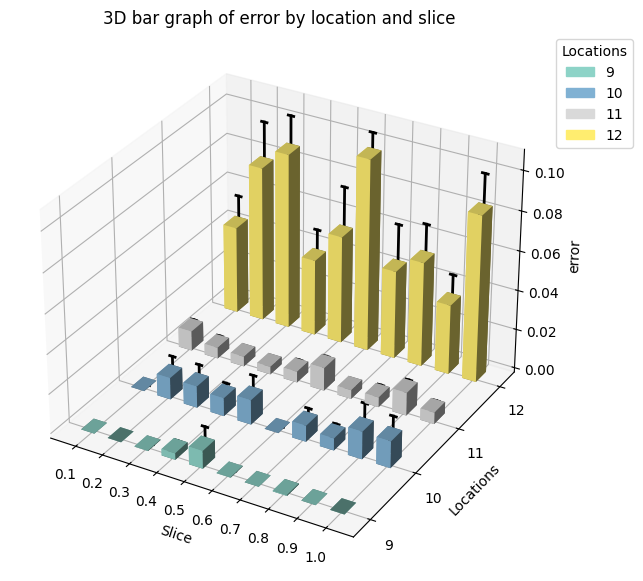

In [16]:
input = 'error'
plot_3d_graph_slice(sliced_summary, input, show_sem=True)

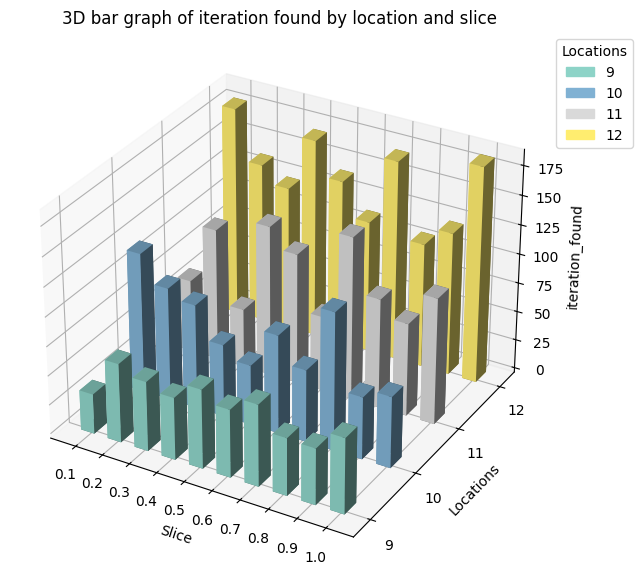

In [17]:
sliced_summary = grouped['iteration_found'].agg(
    mean='mean',
    sem='sem'
).reset_index()

sliced_summary = sliced_summary.rename(columns={'mean': 'iteration_found'})
sliced_summary.head()

input = 'iteration_found'
plot_3d_graph_slice(sliced_summary, input, show_sem=False)

## Analysis of different qml models


In [18]:
qml_mode = read_data()
qml_mode = filter_results_qml(qml_mode)
qml_mode = find_quality(qml_mode, factor=100, round=1)
qml_mode = qml_mode[(qml_mode['slice'] == 0.8)]
qml_mode = qml_mode[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode',]]

qml_mode_pivot = qml_mode.pivot_table(
        index='locations', 
        columns='mode', 
        #index = 'mode',
        values='quality',
        aggfunc=['mean', 'sem', 'count']
)
qml_mode_pivot = qml_mode_pivot.round(1)
print(qml_mode_pivot)

            mean                       sem                count         
mode           1      2      3      4    1    2    3    4     1  2  3  4
locations                                                               
4          100.0  100.0  100.0  100.0  0.0  0.0  0.0  0.0     9  9  9  9
5          100.0  100.0  100.0  100.0  0.0  0.0  0.0  0.0     9  9  9  9
6          100.0  100.0   98.1   99.6  0.0  0.0  1.5  0.4     9  9  9  9
7          100.0  100.0   99.7   97.6  0.0  0.0  0.3  1.6     9  9  9  9
8          100.0  100.0   99.6   96.4  0.0  0.0  0.3  1.8     9  7  9  9
9           98.9  100.0   97.7   93.3  0.8  0.0  1.3  1.9     9  9  9  9
10          98.2   99.4   96.6   91.9  0.9  0.4  1.6  2.2     9  9  9  9
11          98.9   99.5   97.6   96.0  0.2  0.3  1.0  1.0     7  7  7  7
12          95.4   94.7   92.9   88.3  1.2  1.7  1.6  2.5     7  7  7  7


In [19]:
qml_mode_pivot2 = qml_mode.pivot_table(
        #index='locations', 
        #columns='mode', 
        index = 'mode',
        values='quality',
        aggfunc=['mean', 'sem', 'count']
)
qml_mode_pivot2 = qml_mode_pivot2.round(1)
print(qml_mode_pivot2)

        mean     sem   count
     quality quality quality
mode                        
1       99.1     0.2      77
2       99.4     0.2      75
3       98.2     0.4      77
4       96.1     0.6      77


In [20]:
#calculate overall mean for each mode
qml_mode_summary = qml_mode_pivot.mean(axis=0).reset_index()
qml_mode_summary = qml_mode_summary.round(1)
print(qml_mode_summary)

   level_0  mode     0
0     mean     1  99.0
1     mean     2  99.3
2     mean     3  98.0
3     mean     4  95.9
4      sem     1   0.3
5      sem     2   0.3
6      sem     3   0.8
7      sem     4   1.3
8    count     1   8.6
9    count     2   8.3
10   count     3   8.6
11   count     4   8.6


## Analysis of ml models with different numbers of layers

In [21]:
df = read_data()
df = filter_results_ml(df)
df = find_quality(df)
df = select_key_fields_ml(df)
df = df[(df['mode'] == 8)]
df['layers'] = df['layers'].astype(int)

In [22]:
layers_summary = df.groupby(['layers','locations', ]).mean().reset_index()

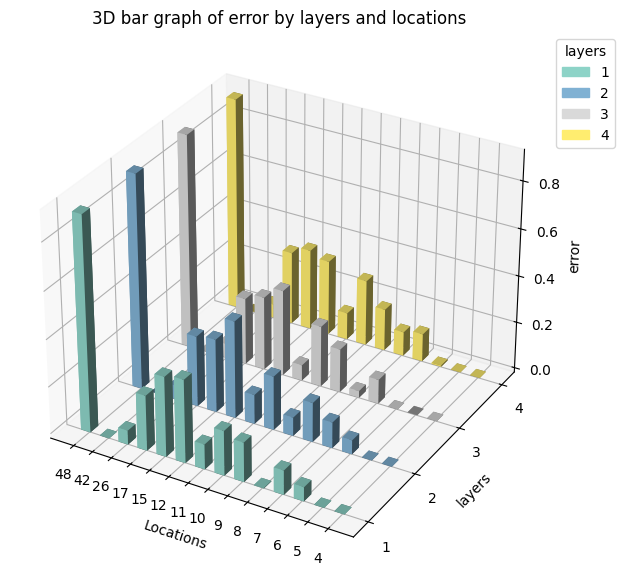

In [23]:
input = 'error'
plot_3d_graph_models(layers_summary, input)

In [24]:
df['quality'] = df['quality']*100
ml_layer_pivot = df.pivot_table(
        index='locations', 
        columns='layers', 
        values='quality',
        aggfunc= ['mean', 'sem', 'count']
        )
ml_layer_pivot = ml_layer_pivot.round(1)
print(ml_layer_pivot)


            mean                       sem           count         
layers         1      2      3      4    1    2    4     1  2  3  4
locations                                                          
4          100.0  100.0  100.0  100.0  NaN  NaN  0.0     1  1  1  6
5          100.0  100.0  100.0  100.0  NaN  NaN  0.0     1  1  1  6
6           94.0   94.0  100.0   99.5  NaN  NaN  0.5     1  1  1  6
7           89.7   89.0   89.7   88.2  NaN  NaN  1.0     1  1  1  6
8           99.8   83.3   97.1   89.7  NaN  NaN  5.2     1  1  1  6
9           83.3   92.1   81.5   82.1  NaN  NaN  2.3     1  1  1  6
10          81.1   77.1   74.1   72.0  4.3  4.5  2.2     3  6  1  6
11          89.4   87.5   93.4   88.5  NaN  NaN  0.5     1  1  1  6
12          64.8   58.8   63.5   68.1  NaN  NaN  4.4     1  1  1  6
15          66.1   69.0   68.8   65.6  NaN  NaN  2.7     1  1  1  6
17          76.6   70.0   71.7   68.9  NaN  NaN  2.6     1  1  1  6
26          94.1   94.1   94.1   94.1  0.0  NaN 

In [25]:
ml_layer_summary = ml_layer_pivot.mean(axis=0).reset_index()
ml_layer_summary = ml_layer_summary.round(1)
ml_layer_summary.head()

,level_0,layers,0
0,mean,1,82.0
1,mean,2,80.3
2,mean,3,81.6
3,mean,4,80.4
4,sem,1,1.4


# Impact of hot start

### QML - hot start

In [26]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = df[(df['noise'] != True)]


df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [27]:
hot_qml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()

In [28]:
hot_qml_pivot = hot_qml_mean.pivot_table(
    index='locations', 
    columns='hot_start', 
    values='quality',
    aggfunc= ['mean', 'sem', 'count']
    )
hot_qml_pivot = hot_qml_pivot.round(1)
print(hot_qml_pivot)

            mean        count      
hot_start  False  True  False True 
locations                          
4          100.0  100.0     1     1
5          100.0  100.0     1     1
6          100.0  100.0     1     1
7          100.0  100.0     1     1
8          100.0  100.0     1     1
9          100.0  100.0     1     1
10          99.4   98.9     1     1
11          99.5  100.0     1     1
12          94.7   93.3     1     1


In [29]:
hot_qml_summary = hot_qml_pivot.mean(axis=0).reset_index()
hot_qml_summary.head()

,level_0,hot_start,0
0,mean,False,99.288889
1,mean,True,99.133333
2,count,False,1.000000
3,count,True,1.000000


### Classical ML - hot start

In [30]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 8)]
df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'hot_start']]


In [31]:
hot_ml_mean = df.groupby(['locations', 'hot_start',]).mean().reset_index()

In [32]:
hot_ml_pivot = hot_ml_mean.pivot_table(
    index='locations', 
    columns='hot_start', 
    values='quality',
    aggfunc= ['mean', 'sem', 'count']
    )
hot_ml_pivot = hot_ml_pivot.round(1)
print(hot_ml_pivot)

            mean        count      
hot_start  False  True  False True 
locations                          
4          100.0  100.0     1     1
5          100.0  100.0     1     1
6           98.3   88.7     1     1
7           88.6  100.0     1     1
8           90.9   94.6     1     1
9           83.3  100.0     1     1
10          75.8   90.5     1     1
11          89.1   93.0     1     1
12          66.2   78.8     1     1
15          66.4   70.4     1     1
17          70.2   70.7     1     1
26          94.1   78.0     1     1
42         100.0   77.7     1     1
48           9.3    9.4     1     1


In [33]:
hot_ml_summary = hot_ml_pivot.mean(axis=0).reset_index()
hot_ml_summary.head()

,level_0,hot_start,0
0,mean,False,80.871429
1,mean,True,82.271429
2,count,False,1.000000
3,count,True,1.000000


## Impact of Gray encoding

### QML - Gray

In [34]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = df[(df['noise'] != True)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'gray']]

gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
if SHOW_COUNTS:
    gray_mean_qml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    gray_mean_qml = df.groupby(['locations', 'gray',]).mean().reset_index()
gray_qml_pivot = gray_mean_qml.pivot_table(index='locations', 
                                           columns='gray', 
                                           values='quality', 
                                           aggfunc= ['mean', 'sem', 'count'])
gray_qml_pivot = gray_qml_pivot.round(1)
print(gray_qml_pivot)


            mean        count      
gray       False  True  False True 
locations                          
4          100.0  100.0     1     1
5          100.0  100.0     1     1
6          100.0  100.0     1     1
7          100.0  100.0     1     1
8          100.0  100.0     1     1
9          100.0   99.4     1     1
10          99.4   98.5     1     1
11          99.5   98.8     1     1
12          94.7   96.7     1     1


In [35]:

gray_summary_qml = gray_qml_pivot.mean(axis=0).reset_index()
gray_summary_qml.head(20)

,level_0,gray,0
0,mean,False,99.288889
1,mean,True,99.266667
2,count,False,1.000000
3,count,True,1.000000


### Classical ML - Gray

In [36]:

df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]
df = df[(df['mode'] == 8)]
df = df[(df['layers'] == 4)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'gray', ]]

if SHOW_COUNTS:
    gray_mean_ml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    gray_mean_ml = df.groupby(['locations', 'gray',]).mean().reset_index()

In [37]:
gray_ml_pivot = gray_mean_ml.pivot_table(index='locations', columns='gray', values='quality')
gray_ml_pivot = gray_ml_pivot.round(1)
print(gray_ml_pivot)

gray       False  True 
locations              
4          100.0  100.0
5          100.0   98.1
6           99.5  100.0
7           88.2   98.9
8           89.7   80.6
9           82.1   78.4
10          72.0   72.0
11          88.5   89.3
12          68.1   70.4
15          65.6   67.1
17          68.9   71.9
26          94.1   93.5
42         100.0  100.0
48           9.4    9.6


In [38]:
gray_summary_ml = gray_mean_ml.groupby(['gray',]).mean().reset_index()
gray_summary_ml.head(20)

,gray,locations,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,False,15.714286,1.0,43.661905,8598.32500,1185.821429,80.441208,19.558792,8.0
1,True,15.714286,1.0,46.493651,8446.50397,1185.821429,80.700148,19.299852,8.0


## Impact of formalation

### QML - formulation

In [39]:
df = read_data()
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['mode'] == 2)]

df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]

df = df[(df['noise'] != True)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 'best_dist_found', 'best_dist', 'quality', 'error','mode', 'formulation',]]

form_mean_qml = df.groupby(['locations', 'formulation',]).mean().reset_index()
if SHOW_COUNTS:
    form_mean_qml = df.groupby(['locations', 'formulation',]).count().reset_index()
else:
    form_mean_qml = df.groupby(['locations', 'formulation',]).mean().reset_index()
form_qml_pivot = form_mean_qml.pivot_table(index='locations', columns='formulation', values='quality')
form_qml_pivot = form_qml_pivot.round(1)
form_qml_pivot = form_qml_pivot.rename(columns={'original': 'non-factorial', 'new': 'factorial'})
print(form_qml_pivot)


formulation  factorial  non-factorial
locations                            
4                100.0          100.0
5                100.0          100.0
6                100.0          100.0
7                100.0          100.0
8                100.0          100.0
9                100.0          100.0
10                99.1           99.4
11                99.2           99.5
12                91.4           94.7


In [40]:
form_summary_qml = form_qml_pivot.mean(axis=0).reset_index()
form_summary_qml.head()

,formulation,0
0,factorial,98.855556
1,non-factorial,99.288889


## Classical ML formulation

In [41]:
df = read_data()
df = df[(df['gray'] == False)]
df = df[(df['hot_start'] == False)]
df = df[(df['iterations'] == 250)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 64)]
df = df[(df['mode'] == 8)]
df = df[(df['layers'] == 4)]
df = df[(df['locations'] < 26)]  #issue calculating large locations

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'formulation', ]]

if SHOW_COUNTS:
    form_mean_ml = df.groupby(['locations', 'formulation',]).count().reset_index()
else:
    form_mean_ml = df.groupby(['locations', 'formulation',]).mean().reset_index()

form_ml_pivot = form_mean_ml.pivot_table(index='locations', columns='formulation', values='quality')
form_ml_pivot = form_ml_pivot.round(1)
form_ml_pivot = form_ml_pivot.rename(columns={'original': 'non-factorial', 'new': 'factorial'})
print(form_ml_pivot)

formulation  factorial  non-factorial
locations                            
4                100.0          100.0
5                100.0          100.0
6                 99.3           99.5
7                 95.5           88.2
8                 81.9           89.7
9                 85.0           82.1
10                76.9           72.0
11                87.4           88.5
12                68.8           68.1
15                69.9           65.6
17                72.6           68.9


In [42]:
form_summary_ml = form_ml_pivot.mean(axis=0).reset_index()
form_summary_ml.head()

,formulation,0
0,factorial,85.209091
1,non-factorial,83.872727


## Impact of changing minibatch size for ML

In [43]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['mode'] == 8)]

df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['runid'] == '20250427-22-43-45')]
df = find_quality(df)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed']]

if SHOW_COUNTS:
    shots_mean_ml = df.groupby(['locations', 'shots',]).count().reset_index()
else:
    shots_mean_ml = df.groupby(['locations', 'shots',]).mean().reset_index()

shots_mean_ml['quality'] = shots_mean_ml['quality']*100

shots_ml_pivot = shots_mean_ml.pivot_table(index='locations', columns='shots', values='quality')
shots_ml_pivot = shots_ml_pivot.round(1)
print(shots_ml_pivot)

shots        2      4      8      16     32     64     128    256
locations                                                        
4          100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
5          100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
6           94.0   94.0   94.0   94.0  100.0  100.0  100.0  100.0
7          100.0   89.7   89.7   87.7   89.0   83.2   89.0  100.0
8           82.4   83.5   82.7   83.3  100.0   87.0  100.0  100.0
9           92.1   83.3   74.0   81.4   92.1   88.9  100.0   99.8
10          64.3   72.9   61.1   73.3   73.7   65.1   88.3   97.3
11          86.3   87.5   87.5   90.7   87.5   88.5   87.5   92.0
12          65.1   65.8   58.8   63.3   70.0   81.9   78.7   88.1
15          59.5   70.8   73.9   65.4   65.5   61.8   73.1   71.9
17          58.3   72.4   72.0   58.3   71.8   73.0   72.6   74.6
26          91.5   92.7   89.0   94.1   94.1   94.1   90.6   90.6
42         100.0  100.0  100.0  100.0  100.0  100.0  100.0  100.0
48        

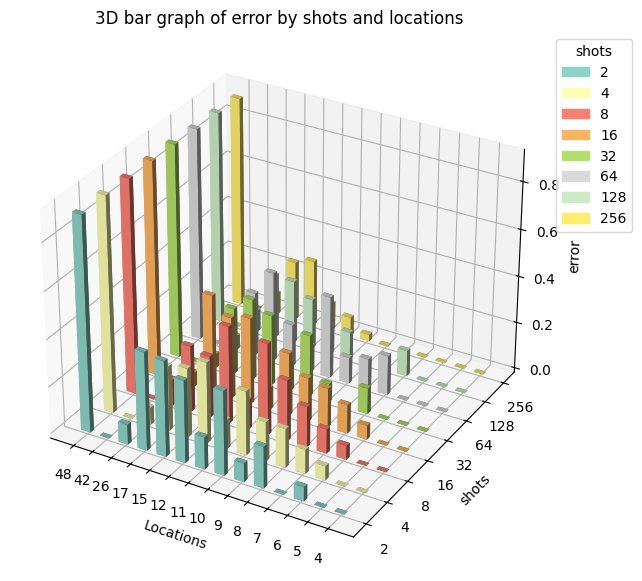

(None,)

In [44]:
input = 'error'
plot_3d_graph_models(shots_mean_ml, input, input2='shots'), 

In [45]:
shots_summary_ml = df.groupby(['shots',]).mean().reset_index()
shots_summary_ml.drop(columns=['locations'], inplace=True)
shots_summary_ml.drop(columns=['error'], inplace=True)
shots_summary_ml['elapsed'] = shots_summary_ml['elapsed'].astype(int)
shots_summary_ml['iteration_found'] = shots_summary_ml['iteration_found'].round(1)
shots_summary_ml['quality'] = shots_summary_ml['quality']*100
shots_summary_ml['quality'] = shots_summary_ml['quality'].round(1)
print(shots_summary_ml.to_string(index=False))

 shots  iteration_found  quality  elapsed
     2             71.0     78.8       20
     4             79.3     80.1       42
     8             49.1     78.0       84
    16             41.2     78.6      166
    32             32.2     82.3      331
    64             35.4     80.9      658
   128             41.2     85.0     1346
   256             35.6     87.4     2891


## Impact of optimiser on Classical ML

In [46]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'].isin([64, 256]))]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['gradient_type'] == 'SGD')]

df = find_quality(df, factor=100)

df_SGD = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'gradient_type']]

In [47]:
df_SGD.head()

,locations,iteration_found,quality,error,shots,elapsed,lr,weight_decay,gradient_type
1153,4,0,100.000000,0.000000,64,36.547650,0.00002,0.0006,SGD
1154,5,0,100.000000,0.000000,64,58.559934,0.00002,0.0006,SGD
1155,6,10,100.000000,0.000000,64,79.682216,0.00002,0.0006,SGD
1156,7,2,89.010638,10.989362,64,107.120503,0.00002,0.0006,SGD
1157,8,6,82.672237,17.327763,64,135.360423,0.00002,0.0006,SGD


In [48]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'].isin([64, 256]))]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['lr'] == 0.001)]
df = df[(df['weight_decay'] == 0.0032)]
df = df[(df['gradient_type'] == 'Adam')]

df = find_quality(df, factor=100)

df_Adam = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'gradient_type']]

df_Adam.head()

,locations,iteration_found,quality,error,shots,elapsed,lr,weight_decay,gradient_type
2006,12,75,87.488958,12.511042,64,329.927990,0.001,0.0032,Adam
2055,4,0,100.000000,0.000000,64,57.947199,0.001,0.0032,Adam
2056,5,0,100.000000,0.000000,64,87.869632,0.001,0.0032,Adam
2057,6,12,100.000000,0.000000,64,109.506645,0.001,0.0032,Adam
2058,7,26,89.675325,10.324675,64,146.107287,0.001,0.0032,Adam


In [49]:
df_combined = pd.concat([df_SGD, df_Adam], ignore_index=True)
df_combined['quality'] = df_combined['quality'].round(1)

In [50]:
if SHOW_COUNTS:
    optimiser_mean_ml = df_combined.groupby(['locations', 'lr', 'gradient_type', 'shots']).count().reset_index()
else:
    optimiser_mean_ml = df_combined.groupby(['locations', 'lr', 'gradient_type', 'shots']).mean().reset_index()

In [51]:
optimiser_mean_ml = optimiser_mean_ml.round(1)
optimiser_mean_ml.head()

,locations,lr,gradient_type,shots,iteration_found,quality,error,elapsed,weight_decay
0,4,0.0,SGD,64,0.0,100.0,0.0,33.7,0.0
1,4,0.0,SGD,256,0.0,100.0,0.0,132.5,0.0
2,4,0.0,Adam,64,0.0,100.0,0.0,39.5,0.0
3,4,0.0,Adam,256,0.0,100.0,0.0,125.8,0.0
4,5,0.0,SGD,64,0.4,100.0,0.0,50.9,0.0


In [52]:
optimiser_ml_pivot = optimiser_mean_ml.pivot_table(
    index='locations', 
    columns=['gradient_type', 'shots'], 
    values='quality',
    aggfunc= ['mean', 'sem', 'count']
    )
optimiser_ml_pivot = optimiser_ml_pivot.round(1)
print(optimiser_ml_pivot)

                mean                      count            
gradient_type   Adam           SGD         Adam     SGD    
shots            64     256    64     256   64  256 64  256
locations                                                  
4              100.0  100.0  100.0  100.0     1   1   1   1
5              100.0  100.0  100.0  100.0     1   1   1   1
6              100.0  100.0   97.8  100.0     1   1   1   1
7               90.5   96.6   90.4  100.0     1   1   1   1
8               93.3   99.9   94.2  100.0     1   1   1   1
9               85.2   92.1   86.6   99.4     1   1   1   1
10              88.7   92.8   77.4   94.6     1   1   1   1
11              91.8   92.9   90.5   94.5     1   1   1   1
12              77.7   77.1   75.6   84.8     1   1   1   1
15              74.4   73.4   69.0   70.8     1   1   1   1
17              59.9   62.1   71.8   76.0     1   1   1   1
26              94.1   94.1   93.3   90.1     1   1   1   1
42             100.0  100.0  100.0  100.

In [53]:
optimiser_ml_summary_pivot = optimiser_mean_ml.pivot_table(
    index='gradient_type', 
    columns=['shots'], 
    values='quality',
    aggfunc='mean'  # or 'first', 'max', etc.
    )
optimiser_ml_summary_pivot = optimiser_ml_summary_pivot.round(1)
print(optimiser_ml_summary_pivot)

shots           64    256
gradient_type            
Adam           83.4  85.3
SGD            82.6  87.2


In [54]:

optimiser_summary_ml = optimiser_mean_ml.pivot_table(index='gradient_type', values='quality')
optimiser_summary_ml.head()

,quality
gradient_type,
Adam,84.353571
SGD,84.860714


### Adam hyperparameter training

In [55]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'] == 64)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 4)]
df = df[(df['locations'] == 12)]
df =df[df['gradient_type'] == 'Adam']
df = find_quality(df, factor=100)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'momentum', ]]

In [56]:
if SHOW_COUNTS:
    adam_mean_ml = df.groupby(['lr', 'weight_decay']).count().reset_index()
else:
    adam_mean_ml = df.groupby(['lr', 'weight_decay']).mean().reset_index()
adam_mean_ml.head()

,lr,weight_decay,locations,iteration_found,quality,error,shots,elapsed,momentum
0,0.00002,0.0000,12.0,79.0,62.859562,37.140438,64.0,312.416320,NaN
1,0.00002,0.0001,12.0,191.0,59.321357,40.678643,64.0,296.820996,NaN
2,0.00002,0.0002,12.0,184.0,58.240252,41.759748,64.0,307.659295,NaN
3,0.00002,0.0004,12.0,223.0,60.345178,39.654822,64.0,283.444793,NaN
4,0.00002,0.0006,12.0,39.0,56.480424,43.519576,64.0,270.237657,0.8


In [57]:
def plot_heatmap(input: pd.DataFrame,
                 title: str,
                 x_label:str,
                 y_label:str,
                 )-> None:
    """Plot a heat map of the given input data."""
    # Prepare the data
    heatmap_data = input.values
    x_labels = input.columns.format()
    y_labels = input.index

    # Create the plot
    plt.figure(figsize=(8, 6))
    im = plt.imshow(heatmap_data, aspect='auto', cmap=CMAP_HEATMAP)

    # Add colorbar
    plt.colorbar(im, label='Solution Quality')

    # Set axis ticks and labels
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels, rotation=45)
    plt.yticks(ticks=np.arange(len(y_labels)), labels=y_labels)

    # Annotate each cell with the numeric value
    for i in range(heatmap_data.shape[0]):       # rows
        for j in range(heatmap_data.shape[1]):   # columns
            value = heatmap_data[i, j]
            if not np.isnan(value):  # skip missing values
                if value > 80:
                    color = 'black'
                else:
                    color = 'white'
                plt.text(j, i, f"{value:.1f}", ha='center', va='center', color=color)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    plt.tight_layout()
plt.show()

C:\Users\DanielGoldsmith\AppData\Local\Temp\ipykernel_55028\347808701.py:9: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  x_labels = input.columns.format()


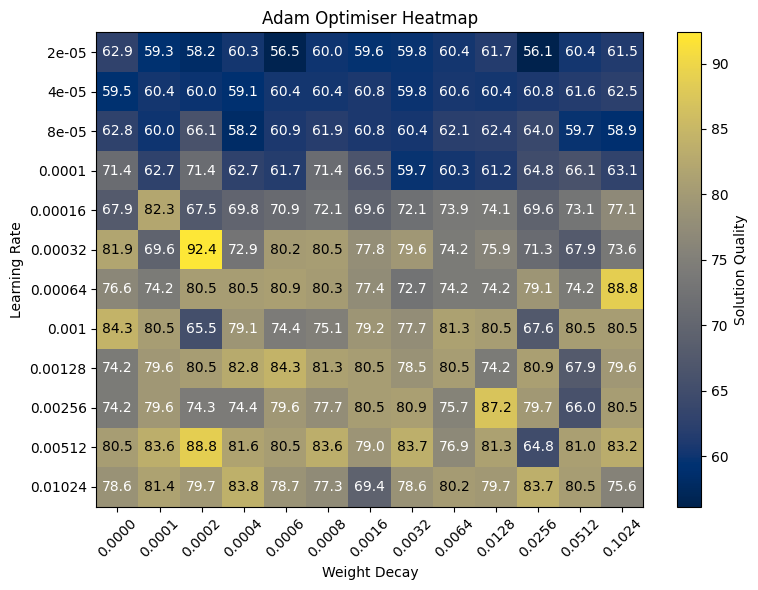

In [58]:
adam_summary_ml = adam_mean_ml.pivot_table(index='lr', columns = 'weight_decay', values='quality')
plot_heatmap(adam_summary_ml, 
             'Adam Optimiser Heatmap',
             'Weight Decay', 
             'Learning Rate', 
             )


## SGD hyper parameter training

In [59]:
df = read_data()
df = df[(df['quantum'] == False)]
df = filter_results_general(df)
df = df[(df['shots'] == 64)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['layers'] == 2)]
df = df[(df['locations'] == 10)]
df =df[df['gradient_type'] == 'SGD']
df =df[df['mode'] == 8]
df = find_quality(df, factor=100)

df = df[['locations', 'iteration_found', 'quality', 
         'error','shots', 'elapsed', 'lr', 'weight_decay', 
         'momentum', 'layers']]

In [60]:
df = df[(df['momentum'] == 0.8)]
if SHOW_COUNTS:
    SGD_mean_ml = df.groupby(['lr', 'weight_decay']).count().reset_index()
else:
    SGD_mean_ml = df.groupby(['lr', 'weight_decay']).mean().reset_index()
SGD_mean_ml.head()

,lr,weight_decay,locations,iteration_found,quality,error,shots,elapsed,momentum,layers
0,0.00001,0.0010,10.0,5.0,72.859656,27.140344,64.0,205.237614,0.8,2.0
1,0.00001,0.0020,10.0,21.0,77.759912,22.240088,64.0,201.277888,0.8,2.0
2,0.00001,0.0040,10.0,17.0,81.038815,18.961185,64.0,196.044414,0.8,2.0
3,0.00001,0.0080,10.0,181.0,88.287189,11.712811,64.0,193.797152,0.8,2.0
4,0.00002,0.0005,10.0,22.0,89.547559,10.452441,64.0,207.884731,0.8,2.0


C:\Users\DanielGoldsmith\AppData\Local\Temp\ipykernel_55028\347808701.py:9: FutureWarning: Index.format is deprecated and will be removed in a future version. Convert using index.astype(str) or index.map(formatter) instead.
  x_labels = input.columns.format()


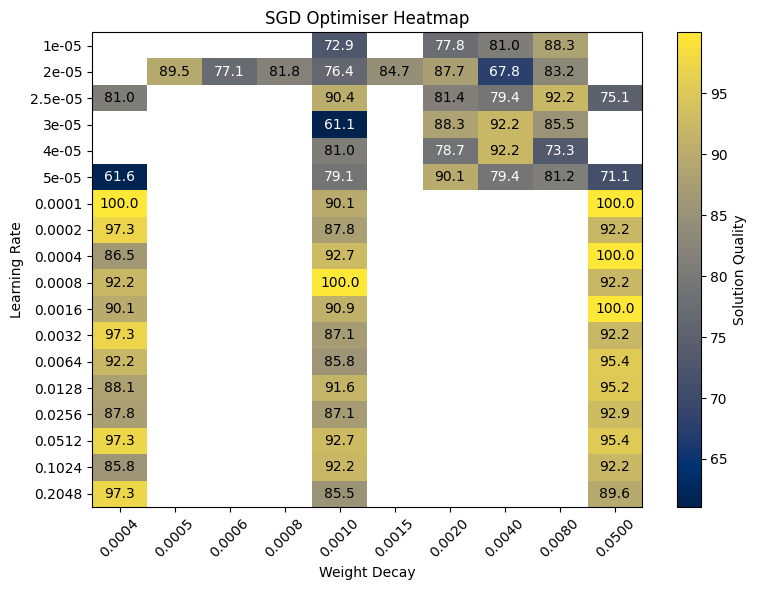

In [61]:
SGD_summary_ml = SGD_mean_ml.pivot_table(index='lr', columns = 'weight_decay', values='quality')
plot_heatmap(SGD_summary_ml, 
             'SGD Optimiser Heatmap',
             'Weight Decay', 
             'Learning Rate', 
             )

## ML initialisation with different values

In [62]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['hot_start'] == False)]
df = df[(df['gray'] == False)]
df = df[(df['iterations'] == 250)]
df = df[(df['quantum'] == False)]
df = df[(df['std_dev'] == 0.05)]
df = df[(df['gradient_type'] == 'SGD')]
df = df[(df['lr'] == 2e-5)]
df = df[(df['weight_decay'] == 0.0006)]
df = df[(df['momentum'] == 0.8)]
df = df[(df['shots'] == 256


)]
df = df[(df['layers'] == 4)]

df = find_quality(df, factor=100)

df = df[['locations', 'slice','iteration_found', 
         'best_dist_found', 'best_dist', 'quality', 
         'error','mode', 'gray', ]]

if SHOW_COUNTS:
    mode_mean_ml = df.groupby(['locations', 'gray',]).count().reset_index()
else:
    mode_mean_ml = df.groupby(['locations', 'gray',]).mean().reset_index()

mode_mean_ml.head()

,locations,gray,slice,iteration_found,best_dist_found,best_dist,quality,error,mode
0,4,False,1.0,0.0,21.000000,21.0,100.000000,0.000000,8.4
1,5,False,1.0,1.6,19.000000,19.0,100.000000,0.000000,8.4
2,6,False,1.0,2.4,241.000000,241.0,100.000000,0.000000,8.4
3,7,False,1.0,11.2,276.200012,276.2,99.999996,0.000004,8.4
4,8,False,1.0,24.8,277.200012,277.2,99.999996,0.000004,8.4


In [63]:
mode_ml_pivot = df.pivot_table(
    index='locations', 
    columns=['mode'], 
    values='quality',
    aggfunc= ['mean', 'sem', 'count']
    )
mode_ml_pivot = mode_ml_pivot.round(1)
print(mode_ml_pivot)

            mean         sem      count   
mode           8      9    8    9     8  9
locations                                 
4          100.0  100.0  0.0  0.0     3  2
5          100.0  100.0  0.0  0.0     3  2
6          100.0  100.0  0.0  0.0     3  2
7          100.0  100.0  0.0  0.0     3  2
8          100.0  100.0  0.0  0.0     3  2
9           99.0  100.0  0.9  0.0     3  2
10          96.6   91.5  0.6  0.6     3  2
11          91.9   98.4  0.9  0.4     3  2
12          84.4   85.2  2.3  0.6     3  2
15          71.3   70.1  0.4  1.2     3  2
17          77.3   74.2  3.1  2.1     3  2
26          89.7   90.6  0.9  0.0     3  2
42         100.0  100.0  0.0  0.0     3  2
48          10.2    9.7  0.2  0.0     3  2


In [100]:
mode_summary_ml_pivot = mode_ml_pivot.mean(axis=0).reset_index()
mode_summary_ml_pivot = mode_summary_ml_pivot.round(1)
mode_summary_ml_pivot.head(10)



,level_0,mode,0
0,mean,8,87.2
1,mean,9,87.1
2,sem,8,0.7
3,sem,9,0.4
4,count,8,3.0
5,count,9,2.0


## Noise

In [141]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
#df = df[(df['iterations'] == 250)]
df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]
#df = df[(df['shots'] == 1024)]
df = df[(df['mode'] == 2)]

df['noise'] = df['noise'].fillna(False)
pd.set_option('future.no_silent_downcasting', True)
df = df[(df['noise'] == True)]

df = find_quality(df, factor=100)

In [142]:
noise_qml_pivot = df.pivot_table(
    #index='locations', 
    index = 'shots',
    #columns=['noise',],
    columns = ['noise', 'iterations',],
    #values= ['quality', 'elapsed', 'cache_items', 'cache_hits',],
    values= ['quality', 'elapsed',],
    #values = ['elapsed'],
    #aggfunc= ['mean', 'sem', 'count',]
    aggfunc= ['mean', ],
    )
noise_qml_pivot = noise_qml_pivot.round(1)
print(noise_qml_pivot)

              mean                                     
           elapsed                quality              
noise         True                   True              
iterations     50     100     250     50     100    250
shots                                                  
16           235.1  500.5     NaN   100.0  100.0    NaN
128          233.6  465.8     NaN   100.0  100.0    NaN
1024         239.9    NaN  3131.8   100.0    NaN  100.0


## Iterations required

In [137]:
df = read_data()
df = df[(df['formulation'] == 'original')]
df = df[(df['gray'] == False)]
#df = df[(df['iterations'] == 250)]
df = df[(df['quantum'] == True)]
df = df[(df['gradient_type'] == 'SPSA')]
df = df[(df['alpha'] == 0.602)]
df = df[(df['big_a'] == 25)]
df = df[(df['c'] == 0.314)]
df = df[(df['gamma'] == 0.101)]
df = df[(df['eta'] == 0.1)]
df = df[(df['s'] == 0.5)]
df = df[(df['slice'] == 0.8)]
df = df[(df['shots'] == 1024)]
df = df[(df['mode'] == 2)]

#df['noise'] = df['noise'].fillna(False)
#pd.set_option('future.no_silent_downcasting', True)
#df = df[(df['noise'] == True)]

df = find_quality(df, factor=100)

In [138]:
iterations_qml_pivot = df.pivot_table(
    index = 'locations',
    columns = [],
    values= ['quality','iteration_found' ],
    aggfunc= ['mean', ],
    )
iterations_qml_pivot = iterations_qml_pivot.round(1)
print(iterations_qml_pivot)

                     mean        
          iteration_found quality
locations                        
4                     0.0   100.0
5                     0.5   100.0
6                     3.1   100.0
7                     1.5   100.0
8                     6.0   100.0
9                    46.2   100.0
10                  132.4    99.2
11                  109.6    99.6
12                  122.4    94.5
